In [1]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [38]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

# 하이퍼 파라미터

In [90]:
w = 2000                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 300                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-6
threshold = 0.5        # Threshold for classifying anomaly (0.5~0.8)

# Data 불러오기 / 임의 생성

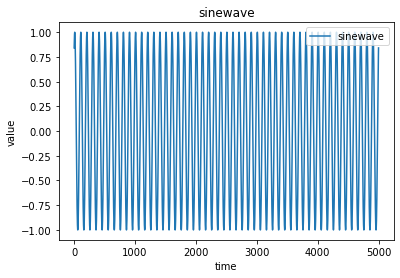

<Figure size 7200x720 with 0 Axes>

,time,sinewave
0,0,0.841471
1,1,0.873736
2,2,0.902554
3,3,0.927809
4,4,0.949402


In [3]:
df_sine = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/sinewave.csv')
plt.plot(df_sine['sinewave'])
plt.title('sinewave')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['sinewave'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()
df_sine.head()

# 데이터 window_size로 나누기

In [49]:
def split_sequence_to_dataset(sequence):
    X, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + w
        out_end_ix = end_ix + p_w
        
        if out_end_ix > len(sequence):
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], n_features)
    y = np.array(y)
    
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    
    tensor_dataset = TensorDataset(X,y)
        
    return tensor_dataset
raw_seq = list(df_sine['sinewave'])

In [50]:
len(raw_seq)

5001

In [51]:
train_dataset = split_sequence_to_dataset(raw_seq)

train_loader = DataLoader(train_dataset, shuffle = False, batch_size = 1 , drop_last=False)

# 모델  만들기

In [52]:
class DeepAnt(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding=0):
        super(DeepAnt,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.conv1d_1 = nn.Conv1d(in_channels,out_channels,kernel_size = kernel_size, 
                                  stride = stride, padding = padding)
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool1d(kernel_size = pool_size_1)
        
        self.conv1d_2 = nn.Conv1d(out_channels,in_channels * out_channels,kernel_size = kernel_size,
                                  stride = stride, padding = padding)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool1d(kernel_size = pool_size_1)
        
        self.dropout = nn.Dropout(p = dropout_rate)
        
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Linear( int((w/4 - 1) * num_filt_1),40)
        self.relu_3 = nn.ReLU()
        
        self.output_dense = nn.Linear(40,p_w)
    
    def forward(self,x):
        x = x.reshape(x.shape[0],x.shape[2],x.shape[1])
        output = self.conv1d_1(x)
        output = self.relu_1(output)
        output = self.maxpool_1(output)
#         print(output.shape) # torch.Size([1, 32, 999])
        
        
        output = self.conv1d_2(output)
        output = self.relu_2(output)
        output = self.maxpool_2(output)
#         print(output.shape) #torch.Size([1, 32, 499])
        
        output = self.flatten(output)
#         print(output.shape)
#         print(int(w * (num_filt_1/4) * num_filt_1))
        output = self.dense_1(output)
#         print(output.shape)
        output = self.relu_3(output)
    
        output = self.dropout(output)
        
        
        output = self.output_dense(output)
        
        return output


In [91]:
model = DeepAnt(in_channels = n_features, out_channels = num_filt_1, kernel_size = kernel_size, stride = conv_strides, padding=0)

In [92]:
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 2e-6 )
# optimizer = optim.SGD(model.parameters(), lr = 0.001 )

# 학습

In [93]:
def training(model,optimizer,loss_func,train_loader,epochs):
    loss_arr = []
    for i in range(epochs):
        
        loss_epoch = []
        count = 0
        
        for j, (x,y) in enumerate(train_loader):
            count += 1
            optimizer.zero_grad()
            
            y = y.float()
            predict = model(x.float())
            
            loss = loss_func(predict,y) 
            loss_epoch.append(loss.detach())
            
            loss.backward()
            optimizer.step()
            
        loss_epoch_ = np.mean(np.array(loss_epoch))    
        loss_arr.append(loss_epoch_)
#         if epochs == 1:
#             print(count)
#   if i %10 == 0:
#     print("%d번째 loss:%d "%(i+1,loss))
    return model, loss_arr

In [94]:
model = model.float()
model, loss_arr = training(model, optimizer, loss_func, train_loader, 30)

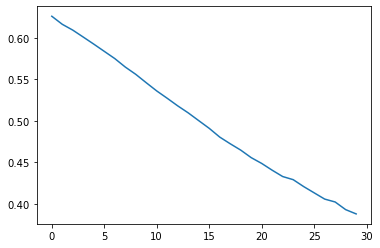

In [95]:
plt.plot(loss_arr)
plt.show()

# 테스트

In [96]:
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
        
        
    batch_test_seq = np.array(batch_test_seq)
    batch_test_seq = batch_test_seq.reshape(batch_test_seq.shape[0], w, n_features)
    batch_test_label = np.array(batch_test_label)
    batch_test_label = batch_test_label.reshape(batch_test_label.shape[0], p_w)
    
    batch_test_seq = torch.from_numpy(batch_test_seq)
    batch_test_label = torch.from_numpy(batch_test_label)
    
    test_dataset = TensorDataset(batch_test_seq,batch_test_label)
        
    return test_dataset

In [97]:
test_dataset = generate_test_batch(list(df_sine['sinewave']), n_test_seq)

test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 1, drop_last=False)

In [98]:
def testing(testdataloader,model_):
    model_.eval()
    loss = 0
    eval_loss = []
    predict_array = []
    count = 0
    with torch.no_grad():
        for i,(x,y) in enumerate(testdataloader):

            y = y.type(torch.int64)
            predict = model_(x.float())
            predict_array.append(predict.reshape(-1))
            loss += loss_func(predict,y)
            
    print('Loss : ', loss)
    
    return predict_array

In [99]:
predicted_seq = testing(test_loader, model)
predicted_seq = np.array(predicted_seq[0])

Loss :  tensor(0.3645)


# 예측 결과 시각화

In [100]:
raw_seq = list(df_sine['sinewave'])
endix = len(raw_seq) - w - p_w
input_seq = array(raw_seq[endix:endix+w])
target_seq = array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))
predicted_seq = model(torch.from_numpy(input_seq).float())

predicted_seq = predicted_seq.detach().numpy()


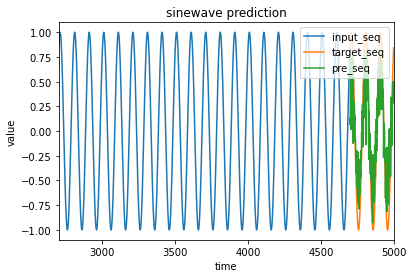

In [101]:
in_seq = df_sine['sinewave'][endix:endix+w]
tar_seq = df_sine['sinewave'][endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': df_sine['time'][endix+w:endix+w+p_w], 'values': predicted_seq}
df_sine_pre = pd.DataFrame(data=d)
pre_seq = df_sine_pre['values']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)
plt.title('sinewave prediction')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'target_seq', 'pre_seq'], loc='upper right')
axes = plt.gca()
axes.set_xlim([endix,endix+w+p_w])
# fig_predict = plt.figure(figsize=(100,10)) 
# fig_predict.savefig('predicted_sequence.png')
plt.show()

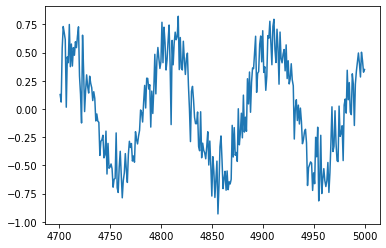

In [102]:
plt.plot(pre_seq)
plt.show()

# Anomaly Detector

In [103]:
def anomaly_detector(data, prediction_seq, ground_truth_seq, threshold):
    label_ = []
    for i in range(len(prediction_seq)):
        dist = np.linalg.norm(ground_truth_seq[i] - prediction_seq[i])
        if (dist > threshold):
            label_.append('1')  # anomaly
        else:
            label_.append('0') # normal
            
    data_ = data.iloc[-len(prediction_seq):,:]
    data_['label'] = label_
    return data_

In [104]:
data__ = anomaly_detector(df_sine,predicted_seq,tar_seq.values, threshold)

/home/seokilee/anaconda3/envs/finance/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [105]:
data__.head()

,time,sinewave,label
4701,4701,0.873736,1
4702,4702,0.902554,1
4703,4703,0.927809,0
4704,4704,0.949402,0
4705,4705,0.967249,0


# 모델 저장하기

In [ ]:
#모델 저장하기
torch.save(model.state_dict(), 'Basic_DeepAnt.pt')